In [19]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from mpl_toolkits import mplot3d

import math

import netCDF4 as nc4

In [20]:
def bed(x,y,abx, DD, rr, ar, lr, Ly, q1, q2, am, lm, Lx , Zmax): 
    y = (0.5*Ly+q1*x*np.exp(-q2*x))*2*y/Ly + am*np.sin(2*np.pi*x/lm)
    rr2=rr+(3.0-rr)*(x/Lx)**0.4
    bed = Zmax - abx*x-DD*(1-(y/(DD*rr2))**2) - ar*np.sin(2*np.pi*x/lr)
    return bed

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [27]:
bed_version = 'bed1'
MinH = 10.0

#Parameters

Zmax=4000.0   # Altitude max
abx= 45*np.pi/180    # Mean bedrock slope [-] - 0.15
aspect=0         # Aspect in degree (E=0 S=90 W=180 N=270)

#========================================

DD=100.0      # valley depth [m] - 500.0
rr=20.0        # lateral aspect ratio [-] - 2.0
ar=0.0        # Roughness amplitude [m] - 0.0
lr=500.0     # Roughness wavelength [m] - infinity
#Ly=Ly,       # Half domain width [m] - 2000.0
q1=0.0        # Width coefficient [-] - 0.0 
q2=1/1000.0   # Width exponent [m^-1] - infinity
am=0.0      # Meander amplitude [m] - 0.0
lm=15000.0    # Wavelength of glacier curvature [m] - 15000.0
Ly = 3000.0   #Domain width

# create a grid with to interpolate teh continuous DEM and save it
# dx = dy = 20

z0=bed(0, 0, abx=abx, DD=DD, rr=rr, ar=ar, lr=lr, Ly=Ly, q1=q1, q2=q2, am=am, lm=lm, Lx=8000,Zmax=Zmax)
Lx = z0/abx
X0 = 0.0
Y0 = 0-Ly/2
dx = 100.0
dy = 100.0
Nx = round(Lx/dx)
Ny = round(Ly/dy)
x = np.linspace(X0,X0+Lx,Nx+1)
y = np.linspace(Y0,Y0+Ly,Ny+1)
X, Y = np.meshgrid(x,y)

zb=None
zb=bed(X, Y, abx=abx, DD=DD, rr=rr, ar=ar, lr=lr, Ly=Ly, q1=q1, q2=q2, am=am, lm=lm, Lx=Lx,Zmax=Zmax)

zbmax=z0+1000-X*abx
zbcut=np.copy(zb)
zbcut[zb>zbmax] = np.nan

In [28]:
# Get contour
xc = np.zeros(6)
yc = np.zeros(6)

xc[0]=0
yc[0]=Ly/2
xc[1]=np.min(X[np.isnan(zbcut)])
yc[1]=Ly/2
xc[2]=Lx
yc[2]=np.max(Y[~np.isnan(zbcut[:,-1])])
xc[3]=Lx
yc[3]=np.min(Y[~np.isnan(zbcut[:,-1])])
xc[4]=np.min(X[np.isnan(zbcut)])
yc[4]=-Ly/2
xc[5]=0
yc[5]=-Ly/2

In [29]:
# Apply rotation :

theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

(X,Y)=rotate((0, 0), (X,Y), math.radians(aspect))
(xc,yc)=rotate((0, 0), (xc,yc), math.radians(aspect))


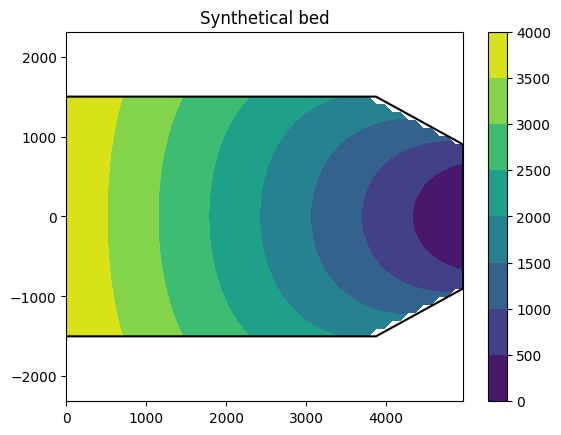

In [30]:
# plot this bed 
plt.figure()
plt.contourf(X, Y, zbcut)
plt.plot(xc,yc,c='k')
#plt.contour(x,y,zb, [4400])
plt.title('Synthetical bed')
plt.colorbar()
plt.axis('equal')
plt.show()


(-248.28171122335698,
 5213.915935690492,
 -2731.0988234569245,
 2731.0988234569245)

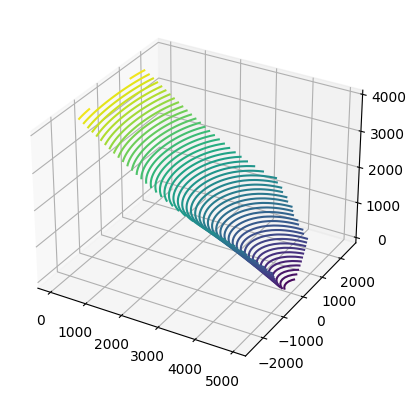

In [31]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, zbcut, 50)
ax.axis('equal')

In [32]:

# Save the contour in an ascii file 
np.savetxt('SyntBed_Contour_'+bed_version+'.dat',np.column_stack((xc,yc)), fmt="%10.2f %10.2f")


# Save it as a netcdf grid
f = nc4.Dataset('SyntBed_DEM_'+bed_version+'.nc','w', format='NETCDF4') 


f.createDimension('x', len(x))
f.createDimension('y', len(y))

xcoord = f.createVariable('X', 'f4', 'x')
ycoord = f.createVariable('Y', 'f4', 'y')
elevation = f.createVariable('bedDEM', 'f4', ('y', 'x'))
surface = f.createVariable('surfDEM', 'f4', ('y', 'x'))

xcoord[:] = x
ycoord[:] = y
elevation[:,:] = zb
surface[:,:] = zb + MinH

xcoord.units = 'm'
xcoord.description = 'dx = '+str(dx)+' m'
ycoord.units = 'm'
ycoord.description = 'dy = '+str(dy)+' m'
elevation.units = 'm'
elevation.description = 'Bed elevation '
surface.units = 'm'
surface.description = 'Surface elevation : Zs = Zb + MinH with MinH = '+str(MinH)+' m'


# Create also scalar variables to save the bed description
abx_v = f.createVariable('abs', 'f4')
abx_v[0] = abx
abx_v.units = '-'
abx_v.long_name = 'Mean berock slope'

DD_v = f.createVariable('DD', 'f4')
DD_v[0] = DD
DD_v.units = 'm'
DD_v.long_name = 'Valley depth'

rr_v = f.createVariable('rr', 'f4')
rr_v[0] = rr
rr_v.units = '-'
rr_v.long_name = 'Lateral aspect ratio'

ar_v = f.createVariable('ar', 'f4')
ar_v[0] = ar
ar_v.units = 'm'
ar_v.long_name = 'Roughness amplitude'

lr_v = f.createVariable('lr', 'f4')
lr_v[0] = lr
lr_v.units = 'm'
lr_v.long_name = 'Roughness wavelength'

Ly_v = f.createVariable('Ly', 'f4')
Ly_v[0] = lr
Ly_v.units = 'm'
Ly_v.long_name = 'Half domain width'

q1_v = f.createVariable('q1', 'f4')
q1_v[0] = q1
q1_v.units = '-'
q1_v.long_name = 'Width coefficient'

q2_v = f.createVariable('q2', 'f4')
q2_v[0] = q2
q2_v.units = 'm^{-1}'
q2_v.long_name = 'Width exponent'

am_v = f.createVariable('am', 'f4')
am_v[0] = am
am_v.units = 'm'
am_v.long_name = 'Meander amplitude'

lm_v = f.createVariable('lm', 'f4')
lm_v[0] = lm
lm_v.units = 'm'
lm_v.long_name = 'Wavelength of glacier curvature'


f.description = 'Synthetical Bedrock from Adhikari PhD 2012'
today = datetime.today()
f.history = "Created " + today.strftime("%d/%m/%y")
f.close()


